In [2]:
import os
import math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.nn import functional as F
from tqdm.auto import tqdm
from models import MultiLayeredPerceptron
from flattened_datasets import MNIST, FashionMNIST
import project_paths as pp
from IPython.display import display, HTML, Markdown, clear_output
from sklearn.metrics import confusion_matrix as cm
from matplotlib import pyplot as plt

KeyboardInterrupt: 

# Pre-Training

## Defining hyper-parameters for training

In [2]:
num_epochs = 30
train_batch_size = 32
val_batch_size = 32
learning_rate = 5e-4
betas = (0.9, 0.98)

## Loading & preparing datasets

In [3]:
dataset = MNIST(train=True)

train_dataset_frac = 0.8
num_instances_in_train_dataset = int(len(dataset) * train_dataset_frac)
num_instances_in_val_dataset = len(dataset) - num_instances_in_train_dataset
train_dataset, val_dataset = random_split(
    dataset,
    [num_instances_in_train_dataset, num_instances_in_val_dataset],
    generator=torch.Generator().manual_seed(1618)
)

num_train_batches = math.ceil(len(train_dataset) / train_batch_size)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

num_val_batches = math.ceil(len(val_dataset) / val_batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

## Loading & preparing model for training

In [4]:
model = MultiLayeredPerceptron()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

In [5]:
total_parameters = 0
num_trainable_parameters = 0
num_non_trainable_parameters = 0
for parameter in model.parameters():
    num_parameters = torch.prod(torch.tensor(parameter.size()))
    total_parameters += num_parameters
    if parameter.requires_grad:
        num_trainable_parameters += num_parameters
    else:
        num_non_trainable_parameters += num_parameters

print(f'Total parameters: {total_parameters}')
print(f'Total trainable parameters: {num_trainable_parameters}')
print(f'Total non-trainable parameters: {num_non_trainable_parameters}')

Total parameters: 932362
Total trainable parameters: 932362
Total non-trainable parameters: 0


In [6]:
models_output_folder_path = os.path.join(pp.models_folder_path, 'MNIST', 'pre_trained')
if not os.path.isdir(models_output_folder_path):
    os.makedirs(models_output_folder_path)

## Training

In [7]:
training_summary = {
    'epoch_number': [],
    'train_loss': [],
    'val_loss': []
}

min_epoch_val_loss = float('inf')

for epoch_idx in range(num_epochs):
    clear_output()
    display(Markdown('**Training Summary**'))
    display(pd.DataFrame.from_dict(training_summary).set_index('epoch_number'))

    training_summary['epoch_number'].append(epoch_idx + 1)
    
    epoch_train_progress_bar = tqdm(total=num_train_batches, desc=f'Training epoch {epoch_idx + 1} of {num_epochs}: ', dynamic_ncols=True)
    model.train()
    epoch_train_loss = 0
    for batch in train_dataloader:
        batch_size = len(batch)
        flattened_images, targets = batch
        predicted = model(flattened_images)
        
        batch_train_loss = loss_function(predicted, targets)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_train_progress_bar.update(1)
    epoch_train_progress_bar.close()
    training_summary['train_loss'].append(epoch_train_loss)

    epoch_val_progress_bar = tqdm(total=num_val_batches, desc=f'Evaluating epoch {epoch_idx + 1} of {num_epochs}: ', dynamic_ncols=True)
    model.eval()
    epoch_val_loss = 0
    for batch in val_dataloader:
        batch_size = len(batch)
        flattened_images, targets = batch
        
        predicted = model(flattened_images)
        
        batch_val_loss = loss_function(predicted, targets)
        epoch_val_loss += batch_val_loss.item()

        epoch_val_progress_bar.update(1)
    epoch_val_progress_bar.close()
    training_summary['val_loss'].append(epoch_val_loss)

    torch.save(model.state_dict(), os.path.join(models_output_folder_path, f'{str(epoch_idx).zfill(2)}.pt'))
    if epoch_val_loss < min_epoch_val_loss:
        torch.save(model.state_dict(), os.path.join(models_output_folder_path, 'least_val_loss.pt'))

clear_output()
display(Markdown('**Training Summary**'))
training_summary = pd.DataFrame.from_dict(training_summary).set_index('epoch_number')
display(training_summary)

**Training Summary**

,train_loss,val_loss
epoch_number,,
1,436.092231,56.669075
2,179.774839,42.776028
3,136.996123,40.365763
4,113.645114,36.864459
5,94.486025,35.860505
6,84.020985,35.426843
7,77.760543,36.995862
8,73.742445,36.963855
9,68.493385,40.582835


# Testing

## Defining hyper-parameters for testing

In [8]:
test_batch_size = 100

## Loading & preparing dataset

In [9]:
test_dataset = MNIST(train=False)
num_instances_in_test_dataset = len(test_dataset)

num_test_batches = math.ceil(len(test_dataset) / test_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size)

## Loading & preparing model for testing

In [10]:
model = MultiLayeredPerceptron()
model.load_state_dict(torch.load(os.path.join(models_output_folder_path, 'least_val_loss.pt'), weights_only=True))
model.eval()

MultiLayeredPerceptron(
  (linear_0): Linear(in_features=784, out_features=512, bias=True)
  (dropout_0): Dropout(p=0.2, inplace=False)
  (relu_0): ReLU(inplace=True)
  (linear_1): Linear(in_features=512, out_features=512, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (relu_1): ReLU(inplace=True)
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (relu_2): ReLU(inplace=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)

## Predicting

In [11]:
# images = []
actual_labels = []
predicted_labels = []

test_dataset_evaluation_progress_bar = tqdm(total=num_test_batches, desc='Evaluating', dynamic_ncols=False)
for batch in test_dataloader:
    flattened_images, targets = batch
    # batch_images = flattened_images.view(-1, 28, 28)
    # for image in batch_images.numpy():
    #     images.append(image)
    
    batch_actual_labels = torch.argmax(targets, dim=-1)
    actual_labels += batch_actual_labels.numpy().tolist()

    predictions = model(flattened_images)
    batch_predicted_labels = torch.argmax(F.softmax(predictions, dim=-1), dim=-1)
    predicted_labels += batch_predicted_labels.numpy().tolist()

    test_dataset_evaluation_progress_bar.update(1)

test_dataset_evaluation_progress_bar.close()
clear_output()

## Computing metrics

In [12]:
accuracy = 0
for actual_label, predicted_label in zip(actual_labels, predicted_labels):
    if actual_label == predicted_label:
        accuracy += 1
accuracy /= len(test_dataset)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9839


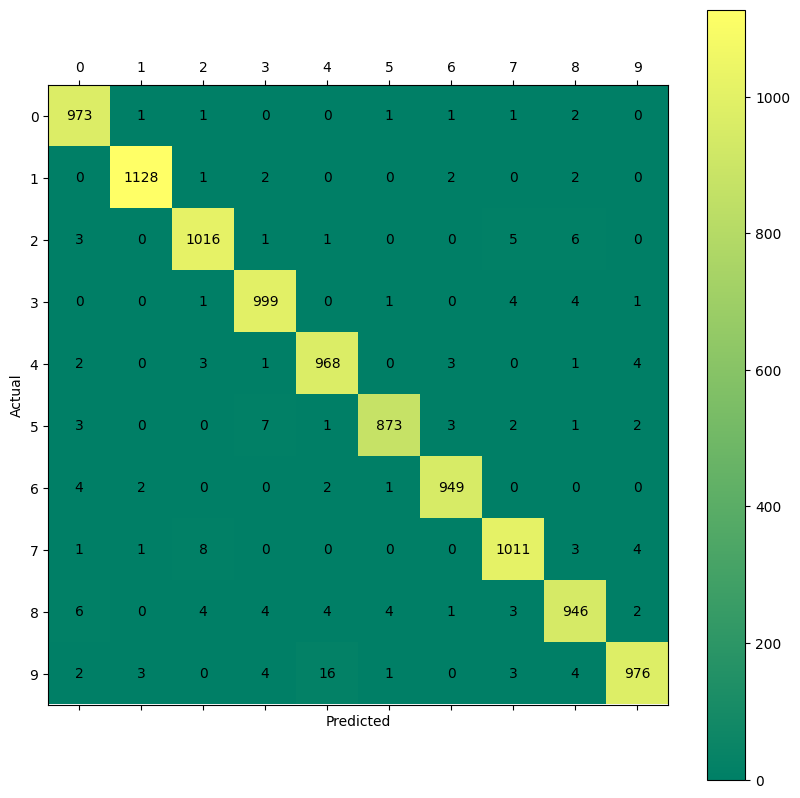

In [13]:
confusion_matrix = cm(actual_labels, predicted_labels)

plt.figure(num='Confusion Matrix', figsize=(10, 10))
plt.matshow(confusion_matrix, cmap='summer', fignum=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
for (i, j), value in np.ndenumerate(confusion_matrix):
    plt.text(j, i, value, ha='center', va='center')
plt.colorbar()
plt.show()